<a href="https://colab.research.google.com/github/GenerouScientist/FaceToon/blob/main/Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
November 26, 2021
Team 29
Final model based on CycleGAN and DCGAN

Since Google collab often crashes with large dataset uploaded, the training result runned below are only for demostration purposes. The actual trained model which can be found under saved model is 
trained locally using one GTX 1660ti and a much larger dataset. Please see the final result of our model with the other collab file for testing.

'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.models

'''
Parameters
'''
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
torch.manual_seed(24)

#target_data_path = "F:\\DATASET\\APS360\\Anime_faces"
#batch_size = 32
#input_data_path = "F:\\DATASET\\APS360\\Human_faces"

'''
These are the folder path to the human and anime training image
'''
target_data_path = "/content/human"
batch_size = 4
input_data_path = "/content/anime"

'''
Real Image dataset
'''
rgbToGray = torch.nn.Sequential(transforms.Grayscale(num_output_channels=1))

                                
'''
Data processing and image normalization
'''

image_transform = transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                
                              
                              ])
'''
Creating the class for custom dataset
'''
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform):
        self.path = folder_path
        self.file_path = os.listdir(self.path)
        self.data = []
        self.transform = transform
        for file_paths in self.file_path:
            image = plt.imread(os.path.join(self.path, file_paths))
            self.data.append(np.array(image))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        self.intToFloat = torch.nn.Sequential(transforms.ConvertImageDtype(torch.float32))
        image = self.intToFloat(torch.from_numpy(self.data[idx]).transpose(0,2))
        return self.transform(image)

target_data = ImageDataset(target_data_path, image_transform)
print("target data loaded...")

def showImg(image):
    figure = plt.figure(figsize=(3,3))
    figure.add_subplot(1,1,1)
    normalized_img = image * 0.5 + 0.5
    plt.imshow(normalized_img.transpose(0,2))


input_data = ImageDataset(input_data_path, image_transform)
print("input data loaded...")

#print(feature_data[2])


target data loaded...
input data loaded...


In [ ]:
'''
Generator

'''
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1, bias = False)
        self.conv2 = nn.Conv2d(8, 16, 5, 2, 2, bias = False)
        self.conv3 = nn.Conv2d(16, 32, 6, 2, 2, bias = False)

        self.convt1 = nn.ConvTranspose2d(32, 16, 6, 2, 2, bias = False)
        self.convt2 = nn.ConvTranspose2d(16, 8, 4, 2, 2, bias = False)
        self.convt3 = nn.ConvTranspose2d(8, 3, 3, 1, 0, bias = False)
        
        self.c1 = nn.Conv2d(3, 12, 3, 1, 1, bias = False)
        self.c2 = nn.Conv2d(12, 24, 4, 2, 1, bias = False)
        self.c3 = nn.ConvTranspose2d(24, 12, 4, 2, 1, bias = False)
        self.c4 = nn.ConvTranspose2d(12, 3, 3, 1, 1, bias = False)

        self.c5 = nn.Conv2d(3, 3, 3, 1, 1, bias = False)
        self.cnorm1 = nn.BatchNorm2d(12)
        self.cnorm2 = nn.BatchNorm2d(24)

        self.norm1 = nn.BatchNorm2d(8)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm2d(32)
        self.norm4 = nn.BatchNorm2d(16)
        self.norm5 = nn.BatchNorm2d(8)
        self.norm6 = nn.BatchNorm2d(3)
        
        self.drop = nn.Dropout(p=0.12)

    def forward(self, x):
        
        #print(x.size())
        #x = x + (0.2)*torch.randn(x.size()[0], 256, 7, 7).cuda() -0.1
        
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.drop(x)
        #print(x.size())
        
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.drop(x)
        
        #print(x.size())
        
        x = F.relu(self.norm3(self.conv3(x)))
        x = self.drop(x)
        
        #print(x.size())
        x = F.relu(self.norm4(self.convt1(x)))
        #print(x.size())
        
        x = F.relu(self.norm5(self.convt2(x)))
        #print(x.size())
        
        x = F.tanh(self.convt3(x))
        #print(x.size())
        
        '''
        x = F.relu(self.cnorm1(self.c1(x)))
        x = self.drop(x)
        x = F.relu(self.cnorm2(self.c2(x)))
        x = self.drop(x)
        x = F.relu(self.cnorm1(self.c3(x)))
        x = F.sigmoid(self.c4(x))
        #x = F.tanh(self.c5(x))
        '''
        
        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Convt') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)    
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        #nn.init.constant_(m.bias.data, 0)


#print(GEN(torch.stack((feature_data[1], feature_data[2]))))

def showTensorImg(net, tensor):
    showImg(net(tensor.cuda().unsqueeze(0)).detach().cpu()[0])
#showTensorImg(GEN, feature_data[1])

'''
Discriminator
'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 4, 2, 1, bias = False)
        self.conv2 = nn.Conv2d(8, 16, 4, 2, 1, bias = False)
        self.conv3 = nn.Conv2d(16, 32, 4, 2, 1, bias = False)
        self.conv4 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.norm1 = nn.BatchNorm2d(8)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 2)
        
        self.conv5 = nn.Conv2d(64, 1, 2, 1, 0, bias = False)
        self.norm4 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 1, 4, 1, 0, bias = False) #4
        
        self.drop = nn.Dropout(p=0.3)
        
        
    def forward(self, x):
        #print(x.size())
        x = F.leaky_relu(self.norm1(self.conv1(x)))
        #print(x.size())
        x = F.leaky_relu(self.norm2(self.conv2(x)))
        #print(x.size())
        x = F.leaky_relu(self.norm3(self.conv3(x)))
        #x = self.drop(x)
        #print(x.size())
        x = F.leaky_relu(self.norm4(self.conv4(x)))
        #x = self.drop(x)
        #print(x.size())
        
        #x = F.sigmoid(self.conv5(x))
        x = F.sigmoid(self.conv6(x))
        #print(x.size())
        return x


#DIS(torch.stack((real_data[1], real_data[2])))

In [ ]:
'''
training
'''

def rgbToGray(tensor):
    a = tensor.transpose(0,1)
    a = 0.299*a[0] + 0.587*a[1] + 0.114 * a[2]
    return a


def train(netDA, netDB, netGA, netGB, dataloaderD, dataloaderG, num_epochs=5, learning_rateD=1e-4, learning_rateGA=1e-4, learning_rateGB = 1e-4, bs= 8, print_every = 2400):
    
    criterion = nn.BCELoss()
    criterion2 = nn.MSELoss()
    #optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rateD, betas=(0.24, 0.999))
    #optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rateG, betas=(0.24, 0.999))
    
    #optimizerD = torch.optim.SGD(netD.parameters(), lr=learning_rateD, weight_decay=0.9)
    #optimizerG = torch.optim.SGD(netG.parameters(), lr=learning_rateG, weight_decay=0.9)
    
    optimizerDA = torch.optim.Adam(netDA.parameters(), lr=learning_rateD, betas=(0.5, 0.999), weight_decay= 0.95)
    optimizerDB = torch.optim.Adam(netDB.parameters(), lr=learning_rateD, betas=(0.5, 0.999), weight_decay= 0.95)
    optimizerGA = torch.optim.Adam(netGA.parameters(), lr=learning_rateGA, betas=(0.5, 0.999))
    optimizerGB = torch.optim.Adam(netGB.parameters(), lr=learning_rateGB, betas=(0.5, 0.999))

    n = 0
    iter_list = []
    list_lossGA = []
    list_lossGB = []
    list_lossDA = []
    list_lossDB = []
    netDA.train()
    netDB.train()
    netGA.train()
    netGB.train()


    for epoch in range(num_epochs):
        for batch, data in enumerate(dataloaderD):
            n += 1
            #print(n)
            
            batch_size = data[0].size()[0]
            real_label = torch.ones(bs).cuda()
            fake_label = torch.zeros(bs).cuda()
            
            netDA.zero_grad()
            
            outDA = netDA(data.cuda()).view(-1)
            #print(outD.size())
            lossDA = criterion(outDA, real_label) #real label
            #print(lossD)
            #lossD.backward()
            
            input_img = next(iter(dataloaderG)).cuda()
            outGA = netGA(input_img)
            #print(outGA.size())
            outDAfromG = netDA(outGA.detach()).cuda().view(-1)
            #print(outDfromG.size())
            lossDAfromG = criterion(outDAfromG, fake_label)
            #print(lossDfromG)
            lossDA = lossDA + lossDAfromG
            lossDA.sum().backward()
            
            optimizerDA.step()
            

            netGA.zero_grad()
            
            outDAfromG = netDA(outGA).view(-1)
            lossGA = criterion(outDAfromG, real_label)#real label
            lossGA.backward()
            optimizerGA.step()
            list_lossGA.append(float(lossGA))
        
            netGB.zero_grad()
            
            outGB = netGB(outGA.detach())
            #print(outGB.size())
            #print(input_img.size())            
            #lossGB = criterion2(outGB, input_img)
            
            #lossGB = criterion2(rgbToGray(outGB), rgbToGray(input_img))
            lossGB = criterion2(outGB, input_img)
            lossGB.backward()
            optimizerGB.step()
            
            
            
            
            #backward cycle
            netDB.zero_grad()

            outDB = netDB(input_img).view(-1)
            lossDB = criterion(outDB, real_label)
            
            outGBback = netGB(data.cuda())
            outDBfromGBback = netDB(outGBback.detach()).cuda().view(-1)
            lossDBfromG = criterion(outDBfromGBback, fake_label)
            lossDB = lossDB + lossDBfromG
            lossDB.sum().backward()
            list_lossDB.append(float(lossDB))
            
            optimizerDB.step()
            
            netGB.zero_grad()
            
            outDBfromGBback = netDB(outGBback).view(-1)
            lossGB = criterion(outDBfromGBback, real_label)
            lossGB.backward()
            optimizerGB.step()
            list_lossGB.append(float(lossGB))

            
            netGA.zero_grad()
            outGA = netGA(outGBback.detach())
            #lossGA = criterion2(rgbToGray(outGA), rgbToGray(data.cuda()))
            lossGA = criterion2(outGA, data.cuda())

            #DourGA = netDB(outGA.detach()).cuda().view(-1)
            #lossGA2 = criterion(DourGA, real_label)
            #FinallossGA = lossGA  #lossGA + lossGA2
            lossGA.backward()
            #FinallossGA.sum().backward()
            optimizerGA.step()
            

            iter_list.append(n)
            
            
            list_lossDA.append(float(lossDA))
            if n % 100 == 0:
                print("iteration:" + str(n) + "|loss(GA/GB/DA/DB):" + str(float(lossGA))+ "|"+ str(float(lossGB))+ "|"+ str(float(lossDA))+ "|"+ str(float(lossDB)))
            if n % print_every == 0:
                #showTensorImg(netGA, target_data[1])
                figure = plt.figure(figsize=(10,10))
                figure.add_subplot(1,2,1)
                plt.imshow(netGB(target_data[16].cuda().unsqueeze(0)).detach().cpu()[0].transpose(0,2)*0.5+0.5)
                figure.add_subplot(1,2,2)
                plt.imshow(target_data[16].transpose(0,2) * 0.5 + 0.5)
                
                #showTensorImg(netGB, target_data[0])
            if n % 2400 == 0:
                torch.save(netGA.state_dict(), "GA_save_" + str(n))
                torch.save(netGB.state_dict(), "GB_save_" + str(n))
                torch.save(netDA.state_dict(), "DA_save_" + str(n))
                torch.save(netDB.state_dict(), "DB_save_" + str(n))
    
    figure1 = plt.figure(figsize=(10,10))
    plt.plot(iter_list, list_lossGA, label = "lossGA")
    plt.plot(iter_list, list_lossGB, label = "lossGB")
    plt.plot(iter_list, list_lossDA, label = "lossDA")
    plt.plot(iter_list, list_lossDB, label = "lossDB")
    plt.title("Training Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    torch.save(netGA.state_dict(), "GA_save_" + str(n))
    torch.save(netGB.state_dict(), "GB_save_" + str(n))
    torch.save(netDA.state_dict(), "DA_save_" + str(n))
    torch.save(netDB.state_dict(), "DB_save_" + str(n))
    #netD.eval()
    #netGA.eval()
    #netGB.eval()

In [ ]:
#datasetD = torchvision.datasets.ImageFolder(root=real_data_path,
                           #transform=transforms.Compose([
                               #transforms.Resize(256),
                                #transforms.CenterCrop(256),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           #]))
#datasetG = torchvision.datasets.ImageFolder(root=feature_data_path,
                           #transform=transforms.Compose([
                               #transforms.Resize(256),
                                #transforms.CenterCrop(256),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           #]))

## Create the dataloader
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         #shuffle=True, num_workers=0)

All data ready... training begin...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


iteration:100|loss(GA/GB/DA/DB):0.38328561186790466|2.4375462532043457|0.45519763231277466|0.2891777753829956
iteration:200|loss(GA/GB/DA/DB):0.4227975010871887|3.2283942699432373|0.21316242218017578|0.13131144642829895
iteration:300|loss(GA/GB/DA/DB):0.3415064215660095|3.4795634746551514|0.15093407034873962|0.1242065578699112
iteration:400|loss(GA/GB/DA/DB):0.29069167375564575|4.696767807006836|0.09968551993370056|0.03314833343029022
iteration:500|loss(GA/GB/DA/DB):0.2738615870475769|4.8486433029174805|0.08697193115949631|0.04891908913850784


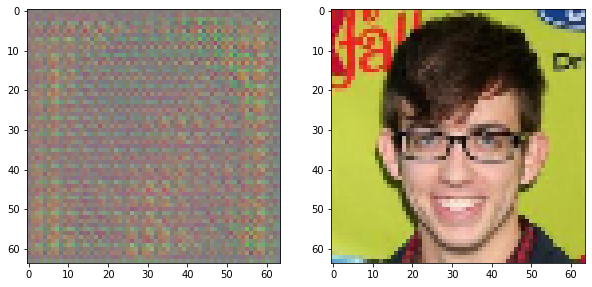

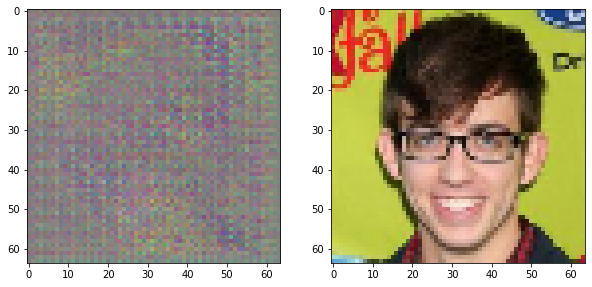

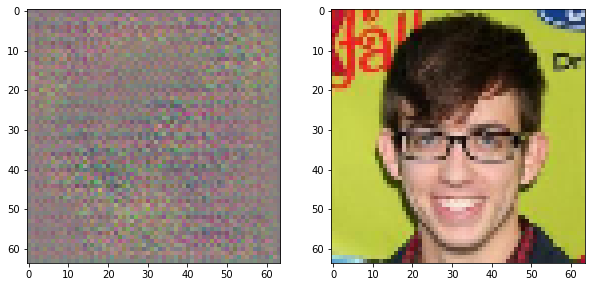

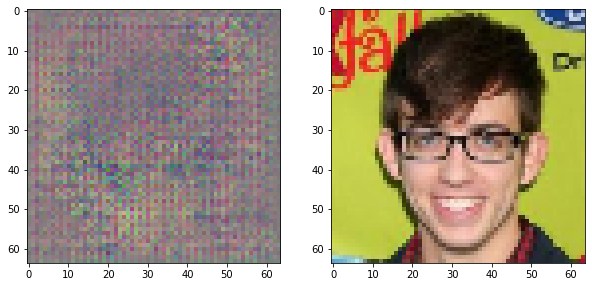

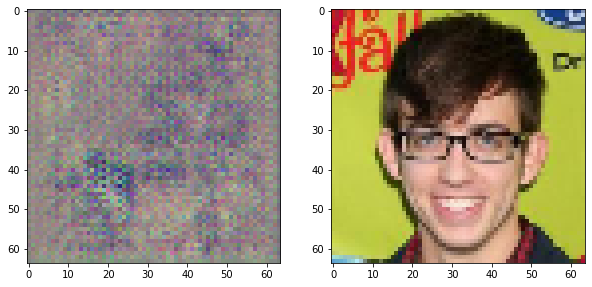

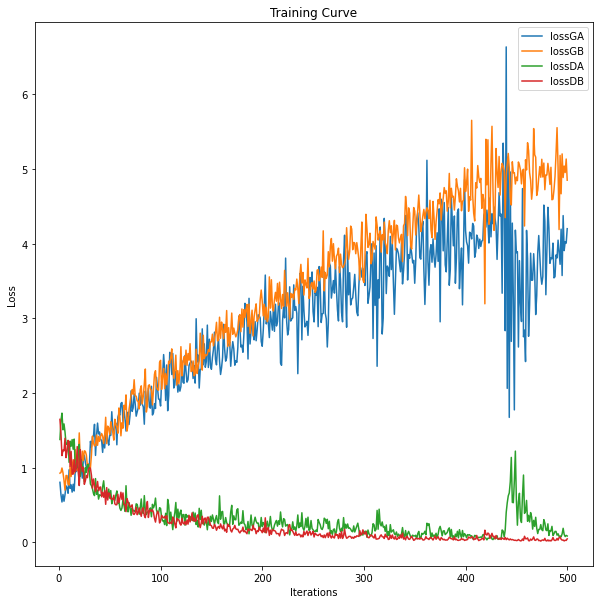

DONE


In [ ]:

GEN_A = Generator().cuda()
GEN_A.apply(weights_init)
GEN_B = Generator().cuda()
GEN_B.apply(weights_init)

DIS_A = Discriminator().cuda()
DIS_A.apply(weights_init)
DIS_B = Discriminator().cuda()
DIS_B.apply(weights_init)

loaderD = torch.utils.data.DataLoader(target_data, batch_size = batch_size, drop_last = True, shuffle = True, num_workers=0)
loaderG = torch.utils.data.DataLoader(input_data, batch_size = batch_size, drop_last = True, shuffle = True, num_workers=0)

#GEN_A.load_state_dict(torch.load("GA_save_1399200"))
#GEN_A.eval()
#GEN_B.load_state_dict(torch.load("GB_save_1399200"))
#GEN_B.eval()


print("All data ready... training begin...")
train(DIS_A, DIS_B, GEN_A, GEN_B, loaderD, loaderG, 100, 0.0002, 0.0008, 0.0008, batch_size, 100)
#train(DIS, GEN, loaderD, loaderG, 100, 2.4e-4, 2e-5, batch_size)
print("DONE")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


iteration:100|loss(GA/GB/DA/DB):0.21445290744304657|5.000885009765625|0.2838367521762848|0.027114596217870712
iteration:200|loss(GA/GB/DA/DB):0.22514915466308594|3.988380193710327|0.049347907304763794|0.06466232985258102
iteration:300|loss(GA/GB/DA/DB):0.28683316707611084|4.939302444458008|0.10409999638795853|0.02748899906873703
iteration:400|loss(GA/GB/DA/DB):0.22838333249092102|4.565406799316406|0.05179990082979202|0.028808139264583588
iteration:500|loss(GA/GB/DA/DB):0.3679835796356201|4.3534746170043945|0.04145418480038643|0.06506893038749695
iteration:600|loss(GA/GB/DA/DB):0.26024743914604187|4.632647514343262|0.05330538749694824|0.024294644594192505
iteration:700|loss(GA/GB/DA/DB):0.2926008701324463|4.342230796813965|0.030521778389811516|0.0304457675665617
iteration:800|loss(GA/GB/DA/DB):0.25527846813201904|3.4696755409240723|0.4358803927898407|0.11112851649522781
iteration:900|loss(GA/GB/DA/DB):0.24299483001232147|4.217278003692627|0.07868227362632751|0.03912810981273651
iteratio

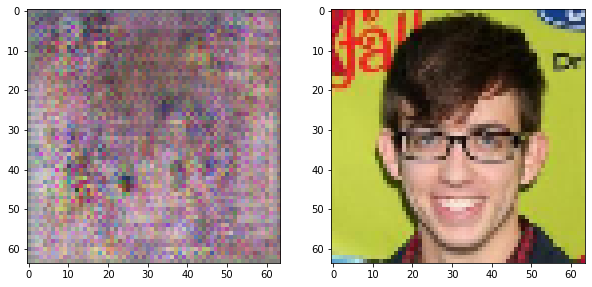

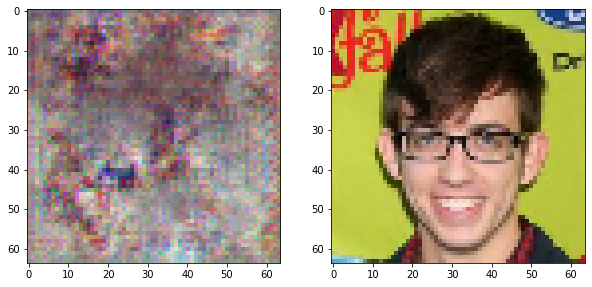

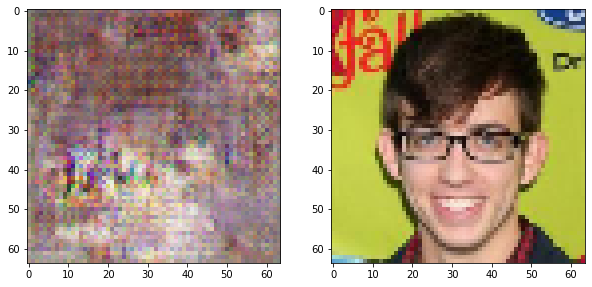

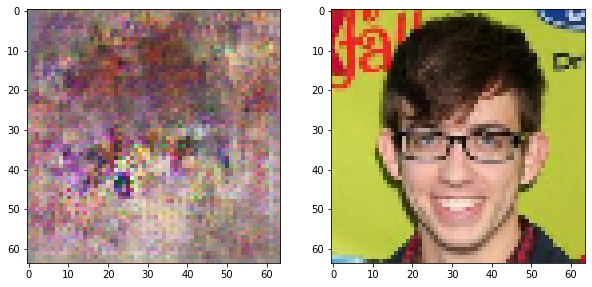

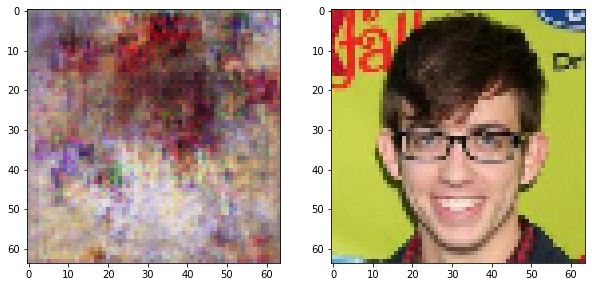

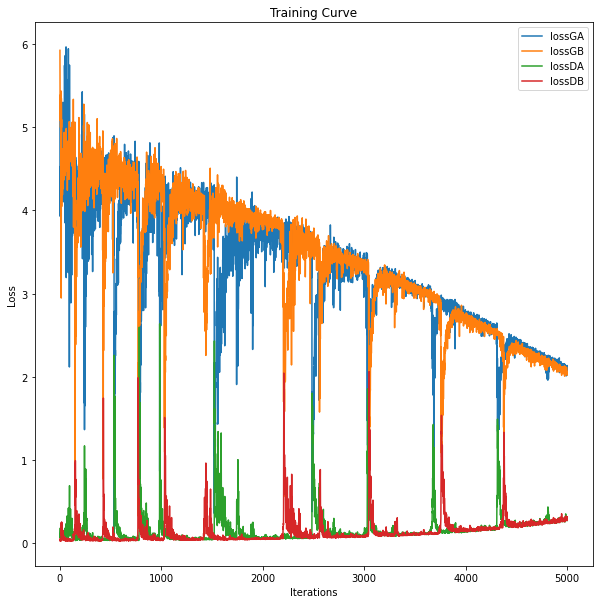

In [ ]:
#train(DIS_A, DIS_B, GEN_A, GEN_B, loaderD, loaderG, 100, 0.0002, 0.0008, 0.0008, batch_size, 500)
train(DIS_A, DIS_B, GEN_A, GEN_B, loaderD, loaderG, 1000, 0.0002, 0.0009, 0.0009, batch_size, 1000)

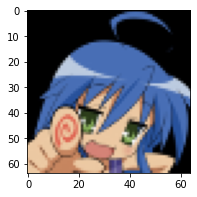

In [ ]:
showImg(input_data[3])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


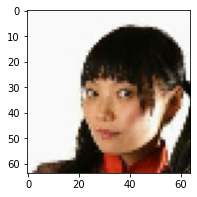

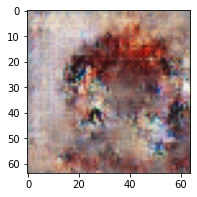

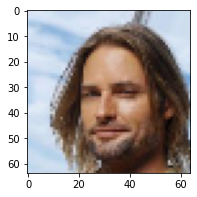

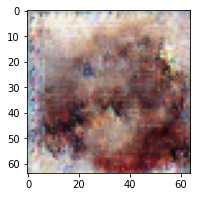

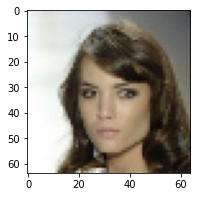

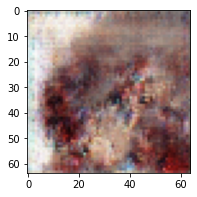

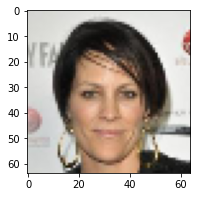

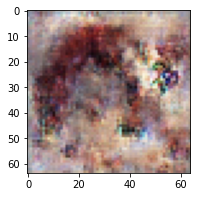

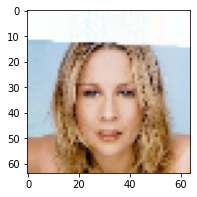

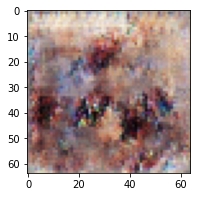

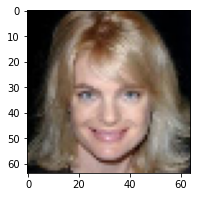

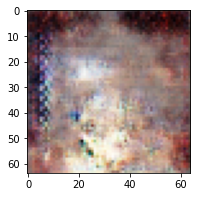

In [ ]:
'''
showTensorImg(GEN_A, target_data[0])
showTensorImg(GEN_B, input_data[0])

showImg(target_data[22])
showTensorImg(GEN_B, target_data[22])

showImg(input_data[3])
showTensorImg(GEN_B, GEN_A(input_data[3].unsqueeze(0).cuda()).detach().squeeze(0))
'''
GEN_B.train()
for j in range(6):
    i = j+1
    showImg(target_data[i])
    showTensorImg(GEN_B, target_data[i])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


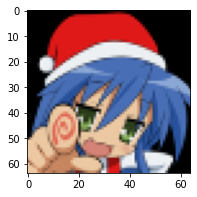

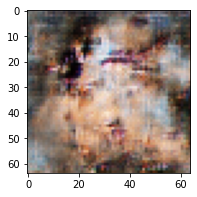

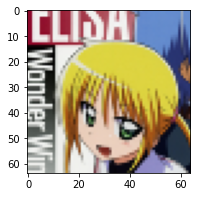

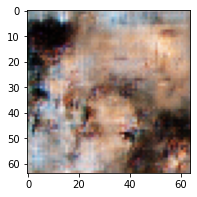

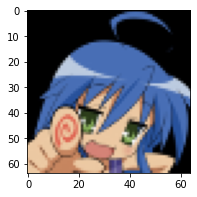

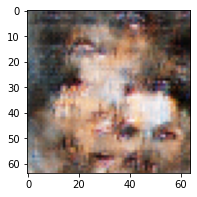

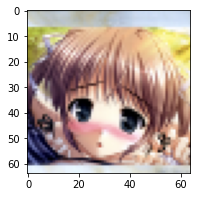

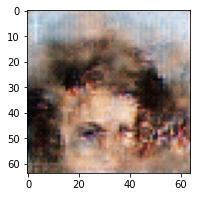

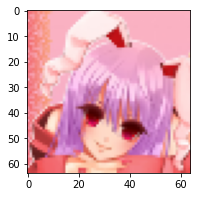

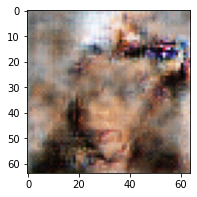

In [ ]:
for j in range(5):
    i = j +1
    showImg(input_data[i])
    showTensorImg(GEN_A, input_data[i])
